In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import cv2
import os

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.applications import InceptionResNetV2
from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.layer_utils import count_params

from sklearn.utils import class_weight
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score

from sklearn.model_selection import train_test_split ,cross_validate , KFold
from sklearn.preprocessing import OneHotEncoder



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Neural Network 2023/HW3/all_data' | wc -l

2975


In [ ]:
LABEL_NAMES = ['Meningioma', 'Glioma' , 'Pituitary']
IMAGE_SIZE = 256
IMAGE_MODE = cv2.IMREAD_COLOR

In [ ]:
def get_data(data_dir):
    """
    Load the image data from the specified directory.

    Args:
        data_dir (str): The directory containing the image data.

    Returns:
        data (numpy.ndarray): An array of image data, where each row contains a
            resized image and its corresponding label.
    """
    data = []
    for label in LABEL_NAMES:
        path = os.path.join(data_dir, label)
        label_num = LABEL_NAMES.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img) , IMAGE_MODE)
                resized_arr = cv2.resize(img_arr, (IMAGE_SIZE, IMAGE_SIZE))
                data.append([resized_arr, label_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data_dir = "./drive/MyDrive/Neural Network 2023/HW3/brain-tumor"

In [ ]:
data = get_data(data_dir)

<ipython-input-8-dbcc55489ffc>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<Axes: ylabel='count'>

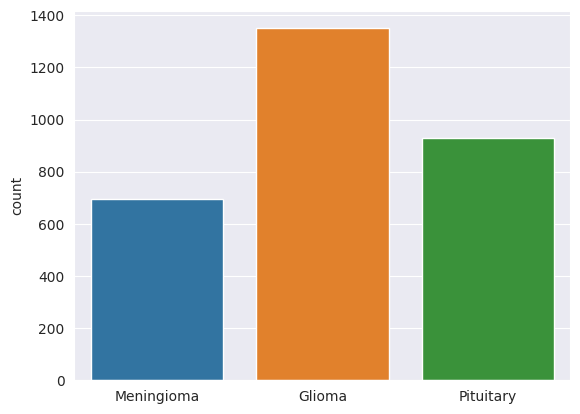

In [ ]:
l = []
for i in data:
    if(i[1] == 0):
        l.append('Meningioma') #Meningioma
    elif(i[1] == 1):
        l.append('Glioma') #Glioma
    else:
        l.append('Pituitary') #Pituitary

sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'Glioma')

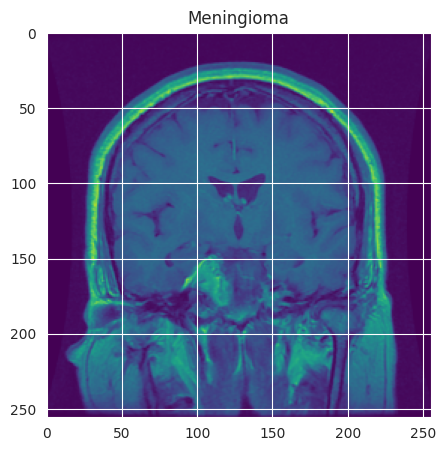

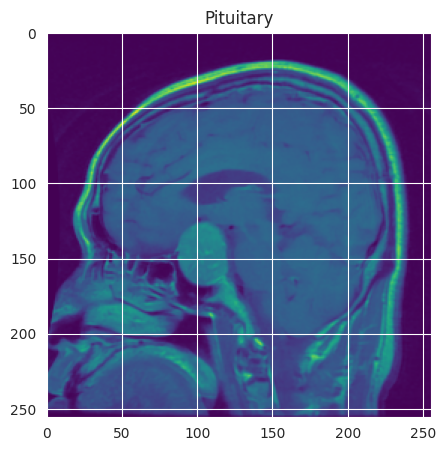

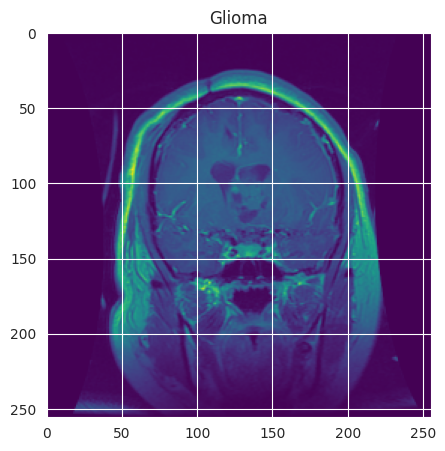

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(cv2.cvtColor(data[0][0], cv2.COLOR_BGR2RGB))
plt.title(LABEL_NAMES[data[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(cv2.cvtColor(data[-1][0], cv2.COLOR_BGR2RGB))
plt.title(LABEL_NAMES[data[-1][1]])


plt.figure(figsize = (5,5))
plt.imshow(cv2.cvtColor(data[int(data.shape[0]/2)][0], cv2.COLOR_BGR2RGB))
plt.title(LABEL_NAMES[data[int(data.shape[0]/2)][1]])

In [ ]:
features = []
labels = []


for feature, label in data:
    features.append(feature)
    labels.append(label)


In [ ]:
features = np.array(features)
labels = np.array(labels)

In [ ]:
print("featurs: " , features.shape)
print("labels: " ,labels.shape)


featurs:  (2974, 256, 256, 3)
labels:  (2974,)


In [ ]:
tr_datagen =  ImageDataGenerator(horizontal_flip=True, vertical_flip=True,rescale=1.0/255)

ts_datagen = ImageDataGenerator(rescale=1.0/255)

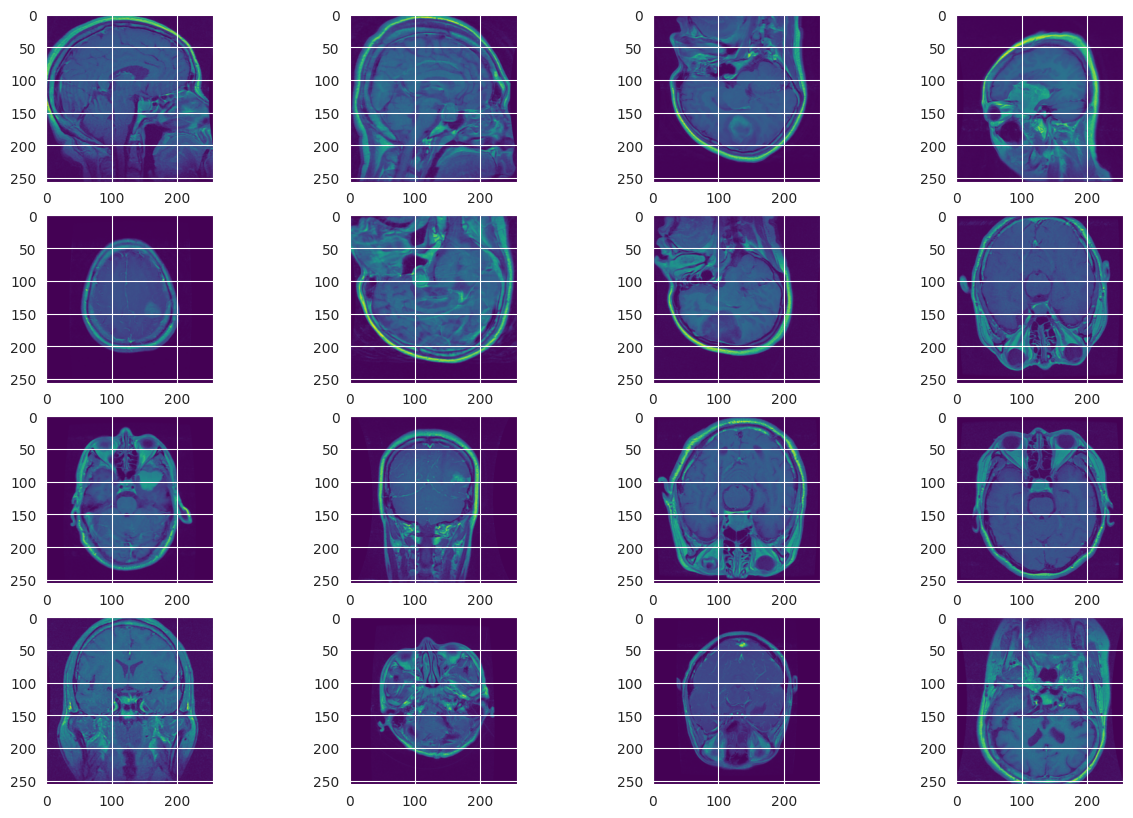

In [ ]:
train_generator = tr_datagen.flow(features, batch_size=1)
rows = 4
columns = 4
fig, axes = plt.subplots(rows,columns)
for r in range(rows):
    for c in range(columns):
        image_batch = train_generator.next().astype(np.float32)
        image = image_batch[0]
        axes[r,c].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
fig.set_size_inches(15,10)

In [ ]:
def create_model():
  num_classes=3
  img_input = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3))
  base_model = InceptionResNetV2(include_top=False,  weights="imagenet", input_tensor=img_input)

  # Freeze the pretrained weights
  base_model.trainable = False


  #TOP
  x = layers.Flatten()(base_model.output)

  # Deep Dense Network
  x = layers.Dense(2048, name="dense_1")(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.4, name="dropout_1")(x)

  x = layers.Dense(2048, name="dense_2")(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.4, name="dropout_2")(x)

  x = layers.Dense(1024, name="dense_3")(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.4, name="dropout_3")(x)

  output = layers.Dense(num_classes, activation='softmax', name="pred")(x)

  # Compile
  model = keras.Model(inputs = img_input, outputs =output , name="InceptionResNetV2")
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(
      optimizer=optimizer,loss='categorical_crossentropy',
      metrics=["accuracy"]
      )
  return model

In [ ]:
model = create_model()
print(model.summary())

In [ ]:
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

In [ ]:
print("trainable_count: " , trainable_count)
print("non_trainable_count: " , non_trainable_count)

trainable_count:  119545859
non_trainable_count:  54336736


In [ ]:
df = pd.read_csv('./drive/MyDrive/Neural Network 2023/HW3/data.csv')
df

,Unnamed: 0,id,label
0,0,2322.png,Meningioma
1,1,2310.png,Meningioma
2,2,2308.png,Meningioma
3,3,2313.png,Meningioma
4,4,2305.png,Meningioma
...,...,...,...
2969,2969,2245.png,Pituitary
2970,2970,2153.png,Pituitary
2971,2971,2127.png,Pituitary
2972,2972,2133.png,Pituitary


In [ ]:
def f(row):
    if row['label'] == 'Meningioma':
        val = "0"
    elif row['label'] == 'Glioma':
        val = "1"
    else:
        val = "2"
    return val

In [ ]:
df['label_num'] = df.apply(f, axis=1)


In [ ]:
df[['id','label','label_num']]

,id,label,label_num
0,2322.png,Meningioma,0
1,2310.png,Meningioma,0
2,2308.png,Meningioma,0
3,2313.png,Meningioma,0
4,2305.png,Meningioma,0
...,...,...,...
2969,2245.png,Pituitary,2
2970,2153.png,Pituitary,2
2971,2127.png,Pituitary,2
2972,2133.png,Pituitary,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['id'],df['label_num'],
                                                    test_size=0.2,
                                                    random_state=42 ,
                                                    stratify=df['label_num'])

In [ ]:
# dealing with class imbalance
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.428828828828829, 1: 0.7342592592592593, 2: 1.0658602150537635}

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy')

In [ ]:
IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)

tr_datagen = ImageDataGenerator( rescale=1.0/255 )
val_datagen = ImageDataGenerator( rescale=1.0/255)

# Training with K-fold cross validation
k_folds = 5
batchSize = 50
kf = KFold(n_splits=k_folds, random_state=None, shuffle=True)
X= np.array(X_train)
histories = []
for train_index, val_index in kf.split(X):
    trainData = X[train_index]
    valData = X[val_index]
    ## create train, valid dataframe and thus train_gen , valid_gen for each fold-loop
    train_df = df.loc[df["id"].isin(list(trainData))]
    valid_df = df.loc[df["id"].isin(list(valData))]
    #create model object
    model= create_model()
    all_labels = [ "0" , "1" , "2" ]
    train_gen = tr_datagen.flow_from_dataframe(dataframe=train_df,
                                         directory="./drive/MyDrive/Neural Network 2023/HW3/all_data/",
                                         x_col = 'id',
                                         y_col = 'label_num',
                                         class_mode = 'categorical',
                                         classes = all_labels,
                                         target_size = IMG_SIZE,
                                         color_mode = 'rgb',
                                         batch_size= batchSize)
    valid_gen = val_datagen.flow_from_dataframe(dataframe=valid_df,
                                         directory="./drive/MyDrive/Neural Network 2023/HW3/all_data/",
                                         x_col = 'id',
                                         y_col = 'label_num',
                                         class_mode = 'categorical',
                                         classes = all_labels,
                                         target_size = IMG_SIZE,
                                         color_mode = 'rgb',
                                         batch_size= batchSize)

    hist = model.fit_generator(
            train_gen,
            steps_per_epoch= len(trainData) // batchSize,
            class_weight = class_weights,
            epochs= 40,
            validation_data=valid_gen,
            callbacks = [learning_rate_reduction])
    histories.append(hist)


Found 1903 validated image filenames belonging to 3 classes.
Found 476 validated image filenames belonging to 3 classes.


<ipython-input-70-26e2d8fe87fa>:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/40
38/38 [==============================] - 55s 1s/step - loss: 2.5725 - accuracy: 0.6104 - val_loss: 0.9813 - val_accuracy: 0.7647 - lr: 1.0000e-04
Epoch 2/40
38/38 [==============================] - 40s 1s/step - loss: 1.4368 - accuracy: 0.7550 - val_loss: 0.8796 - val_accuracy: 0.8046 - lr: 1.0000e-04
Epoch 3/40
38/38 [==============================] - 39s 1s/step - loss: 1.2138 - accuracy: 0.7814 - val_loss: 0.5731 - val_accuracy: 0.8529 - lr: 1.0000e-04
Epoch 4/40
38/38 [==============================] - 40s 1s/step - loss: 0.8753 - accuracy: 0.8327 - val_loss: 0.6801 - val_accuracy: 0.8235 - lr: 1.0000e-04
Epoch 5/40
38/38 [==============================] - 40s 1s/step - loss: 0.6649 - accuracy: 0.8397 - val_loss: 0.7262 - val_accuracy: 0.8424 - lr: 1.0000e-04
Epoch 6/40
38/38 [==============================] - 37s 967ms/step - loss: 0.9155 - accuracy: 0.8300 - val_loss: 2.1822 - val_accuracy: 0.6723 - lr: 1.0000e-04
Epoch 7/40
38/38 [==============================] - 37s

<ipython-input-70-26e2d8fe87fa>:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/40
38/38 [==============================] - 54s 1s/step - loss: 2.2671 - accuracy: 0.6242 - val_loss: 0.5791 - val_accuracy: 0.8319 - lr: 1.0000e-04
Epoch 2/40
38/38 [==============================] - 37s 983ms/step - loss: 2.0003 - accuracy: 0.7221 - val_loss: 0.7082 - val_accuracy: 0.8214 - lr: 1.0000e-04
Epoch 3/40
38/38 [==============================] - 38s 988ms/step - loss: 1.4255 - accuracy: 0.7669 - val_loss: 0.7161 - val_accuracy: 0.8151 - lr: 1.0000e-04
Epoch 4/40
38/38 [==============================] - 36s 958ms/step - loss: 1.2101 - accuracy: 0.7901 - val_loss: 0.4274 - val_accuracy: 0.8887 - lr: 1.0000e-04
Epoch 5/40
38/38 [==============================] - 40s 1s/step - loss: 0.8983 - accuracy: 0.8467 - val_loss: 0.9776 - val_accuracy: 0.8088 - lr: 1.0000e-04
Epoch 6/40
38/38 [==============================] - 40s 1s/step - loss: 1.0272 - accuracy: 0.8163 - val_loss: 0.5059 - val_accuracy: 0.8803 - lr: 1.0000e-04
Epoch 7/40
38/38 [==============================]

<ipython-input-70-26e2d8fe87fa>:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/40
38/38 [==============================] - 53s 1s/step - loss: 2.5104 - accuracy: 0.6147 - val_loss: 0.9214 - val_accuracy: 0.7899 - lr: 1.0000e-04
Epoch 2/40
38/38 [==============================] - 38s 986ms/step - loss: 1.4977 - accuracy: 0.7561 - val_loss: 0.9625 - val_accuracy: 0.8235 - lr: 1.0000e-04
Epoch 3/40
38/38 [==============================] - 38s 986ms/step - loss: 1.1069 - accuracy: 0.8079 - val_loss: 0.7885 - val_accuracy: 0.8193 - lr: 1.0000e-04
Epoch 4/40
38/38 [==============================] - 38s 988ms/step - loss: 1.0618 - accuracy: 0.8176 - val_loss: 0.9907 - val_accuracy: 0.8130 - lr: 1.0000e-04
Epoch 5/40
38/38 [==============================] - 37s 983ms/step - loss: 0.7345 - accuracy: 0.8527 - val_loss: 0.6041 - val_accuracy: 0.8403 - lr: 1.0000e-04
Epoch 6/40
38/38 [==============================] - 37s 984ms/step - loss: 0.7045 - accuracy: 0.8624 - val_loss: 0.4353 - val_accuracy: 0.8676 - lr: 1.0000e-04
Epoch 7/40
38/38 [=========================

<ipython-input-70-26e2d8fe87fa>:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/40
38/38 [==============================] - 53s 1s/step - loss: 2.4497 - accuracy: 0.6260 - val_loss: 0.5014 - val_accuracy: 0.8256 - lr: 1.0000e-04
Epoch 2/40
38/38 [==============================] - 36s 955ms/step - loss: 1.8961 - accuracy: 0.7102 - val_loss: 0.4561 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 3/40
38/38 [==============================] - 37s 962ms/step - loss: 1.2107 - accuracy: 0.7890 - val_loss: 0.4301 - val_accuracy: 0.8718 - lr: 1.0000e-04
Epoch 4/40
38/38 [==============================] - 37s 973ms/step - loss: 1.1619 - accuracy: 0.8009 - val_loss: 0.4825 - val_accuracy: 0.8634 - lr: 1.0000e-04
Epoch 5/40
38/38 [==============================] - 38s 980ms/step - loss: 0.8929 - accuracy: 0.8257 - val_loss: 0.5052 - val_accuracy: 0.8550 - lr: 1.0000e-04
Epoch 6/40
38/38 [==============================] - 37s 975ms/step - loss: 0.6459 - accuracy: 0.8564 - val_loss: 0.7820 - val_accuracy: 0.8319 - lr: 1.0000e-04
Epoch 7/40
38/38 [=========================

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
